## Vigiliant Asset Allocation with momentum
Representative asset classes including Market Index ETF, sector etf, bond etf   
Result is driven from 2007 to 2022 market data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)

In [3]:
import quantstats
from scipy.optimize import minimize

In [4]:
start_date='2006-01-01'
end_date='2022-10-01'
cost=0.001

In [5]:
custom_universe =[
    # Offensive Assets
    "SPY",  # iShares Core S&P 500 ETF                              2000-05-15
    "EFA",  # iShares MSCI EAFE ETF                                 2001-08-02
    "EEM",  # iShares MSCI Emerging Markets ETF                     2003-04-07
    "LQD",  # iShares iBoxx $ Investment Grade Corporate Bond ETF   2002-07-22

    # Defensive Assets
    "SHY",  # iShares 1-3 Year Treasury Bond ETF                    2002-07-22
    "AGG",  # iShares Core U.S. Aggregate Bond ETF                  2003-09-02
    "IEF",  # iShares 7-10 Year Treasury Bond ETF                   2002-07-22
    "TIP"   # iShares TIPS Bond ETF                                 2003-12-04
    ]

In [6]:
print("current directory is : ", os.getcwd())
os.chdir('/mnt/c/workspace/asset_allocation_strategy/')
print("changed directory is : ", os.getcwd())

current directory is :  /mnt/c/workspace/asset_allocation_strategy
changed directory is :  /mnt/c/workspace/asset_allocation_strategy


In [7]:
from backtest.backtest_engine import BacktestEngine
from backtest.target_generator import TargetGenerator

In [8]:
from benchmark_strategy.equal_weight import EqualWeightGenerator
from benchmark_strategy._60_40_allocation import _60_40_allocation

[__init__] is executed in 4.59 seconds
[__init__] is executed in 4.01 seconds


### Load Data of each asset classes
#### Use representative ETF to model strategy. Data should be in yld format
#### [rows : Dates, Columns : Asset Classes, yld = log(currnet_period_price/previous_period_price]

In [9]:
class VAA(TargetGenerator):
    def __init__(self, cache):
        super().__init__(cache)
    
    def compute_target(self, universe_list):
        """
        Inputs
            universe_list(list) : list of ETFs that weights should be computed
        Outputs
            target_weight(dict)
        """
        date = engine.date
        target_weight = {}
        target_weight =  self.compute_factor(date = date, tickers=universe_list)

        return target_weight
    
    def compute_factor(self, date, tickers):
        """
        to calculate r
        :param covariance_matrix: covariance matrix of assets in universe
        :return: [list] weight of risk parity investment strategy
        """
        date_12_month_lag = date - relativedelta(months=12)
        return_df = pd.DataFrame()
        for ticker in tickers:
            asset_series = self.cache['index'][ticker]['closeadj']
            asset_series.rename(ticker, inplace=True)
            return_df[ticker] = asset_series

        return_df = return_df.loc[date_12_month_lag : date]
        return_df =  return_df.pct_change().fillna(0)

        target = {} 
        
        result = self.vaa_momentum(return_df)
        for ticker in return_df.columns:
            target[ticker] = result.loc[date, ticker]

        return target


    def get_momentum(self, yld_df):
        """
        calculate momentum of sectors. use 12 month, 6 month, 3 month momentum to bit market
        input
        yiled_df : dataframe with weekly yield of asset classes

        returns : momentum in pandas dataframe format. momentum of each asset classes for give date
        """
        momentum = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
        
        windows = 250
        for ticker in yld_df.columns:
            i = 0 
            for date in yld_df.index:
                # 250 days before = 1 year  before
                if i > windows :
                    # first 12 month data (52 data points) cannot be used since 12 month lagged returns is required
                    momentum.loc[date, ticker] = yld_df[ticker].iloc[i] / yld_df[ticker].iloc[i - windows] - 1
                    
                    current = yld_df[ticker].iloc[i]
                    before_1m = yld_df[ticker].iloc[i-20]
                    before_3m = yld_df[ticker].iloc[i-60]
                    before_6m = yld_df[ticker].iloc[i-120]
                    before_12m = yld_df[ticker].iloc[i-250]

                    momentum.loc[date, ticker] = 12*(current/before_1m - 1) + 4*(current/before_3m - 1) \
                                                + 2*(current/before_6m - 1) + 1*(current/before_12m - 1)
                
                else:
                    momentum.loc[date, ticker] = 0
                i = i + 1

        momentum = momentum.replace([np.inf], 1000)
        momentum = momentum.replace([-np.inf], -1000)
        momentum = momentum.replace([np.nan], 0)
        return momentum

    def select_sector(self, yld_df):
        """
        select top 4 offensive sectors if condition satisfied.
        If failed to satisfy offensive condition, escape to Defensive strategy.

        Criteria: if any of offensive asset classes show negative momentum score, escape to defensive assets.

        returns: selected_tickers in list format. list with top 5 momentum in given period`
        """
        # inherit previous method and run
        momentum_df = self.get_momentum(yld_df)

        selected_momentum = pd.DataFrame(
            columns=['momentum_1','momentum_2','momentum_3','momentum_4'],
            index=momentum_df.index
        )
        selected_ticker = pd.DataFrame(
            columns=['momentum_1','momentum_2','momentum_3','momentum_4'],
            index=momentum_df.index
        )

        # print("S&P500 market signal : Total ",momentum_df.count()[0])
        # print("postive signal : ", momentum_df[momentum_df['SPY'] >= 0]['SPY'].count())
        # print("negative signal : ", momentum_df[momentum_df['SPY'] < 0]['SPY'].count())


        # print("Developed market signal : Total ",momentum_df.count()[0])
        # print("postive signal : ", momentum_df[momentum_df['EFA'] >= 0]['EFA'].count())
        # print("negative signal : ", momentum_df[momentum_df['EFA'] < 0]['EFA'].count())

        # print("Emerging market signal : Total ",momentum_df.count()[0])
        # print("postive signal : ", momentum_df[momentum_df['EEM'] >= 0]['EEM'].count())
        # print("negative signal : ", momentum_df[momentum_df['EEM'] < 0]['EEM'].count())

        # print("Corporate bond market signal : Total ",momentum_df.count()[0])
        # print("postive signal : ", momentum_df[momentum_df['LQD'] >= 0]['LQD'].count())
        # print("negative signal : ", momentum_df[momentum_df['LQD'] < 0]['LQD'].count())

        for date in momentum_df.index:
            snp_momentum = momentum_df.loc[date,'SPY']
            dev_momentum = momentum_df.loc[date,'EFA']
            eme_momentum = momentum_df.loc[date,'EEM']
            bnd_momentum = momentum_df.loc[date,'LQD']

            short_momentum = momentum_df.loc[date,'SHY']
            mid_momentum   = momentum_df.loc[date,'AGG']
            long_momentum  = momentum_df.loc[date,'IEF']
            tip_momentum   = momentum_df.loc[date,'TIP']

            if snp_momentum >= 0 and dev_momentum >= 0 and eme_momentum >= 0 and bnd_momentum >= 0:
                selected_momentum.loc[date,'momentum_1'] = snp_momentum
                selected_ticker.loc[date,'momentum_1'] = 'SPY'

                selected_momentum.loc[date,'momentum_2'] = dev_momentum
                selected_ticker.loc[date,'momentum_2'] = 'EFA'

                selected_momentum.loc[date,'momentum_3'] = eme_momentum
                selected_ticker.loc[date,'momentum_3'] = 'EEM'

                selected_momentum.loc[date,'momentum_4'] = bnd_momentum
                selected_ticker.loc[date,'momentum_4'] = 'LQD'

            else:
                selected_momentum.loc[date,'momentum_1'] = short_momentum
                selected_ticker.loc[date,'momentum_1'] = 'SHY'

                selected_momentum.loc[date,'momentum_2'] = mid_momentum
                selected_ticker.loc[date,'momentum_2'] = 'AGG'

                selected_momentum.loc[date,'momentum_3'] = long_momentum
                selected_ticker.loc[date,'momentum_3'] = 'IEF'

                selected_momentum.loc[date,'momentum_4'] = tip_momentum
                selected_ticker.loc[date,'momentum_4'] = 'TIP'

        return selected_ticker

    def vaa_momentum(self, yld_df):
        """
        returns : market portfolio in pandas dataframe format.
        """
        mom_ticker_df = self.select_sector(yld_df)
        mp_table = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
        for date in mom_ticker_df.index:
            selected = mom_ticker_df.loc[date].tolist()
            for sel in selected:
                mp_table.loc[date, sel] = 1/4
        mp_table = mp_table.fillna(0)
        return mp_table

In [10]:
custom_universe =[
    # Offensive Assets
    "SPY",  # iShares Core S&P 500 ETF                              2000-05-15
    "EFA",  # iShares MSCI EAFE ETF                                 2001-08-02
    "EEM",  # iShares MSCI Emerging Markets ETF                     2003-04-07
    "LQD",  # iShares iBoxx $ Investment Grade Corporate Bond ETF   2002-07-22

    # Defensive Assets
    "SHY",  # iShares 1-3 Year Treasury Bond ETF                    2002-07-22
    "AGG",  # iShares Core U.S. Aggregate Bond ETF                  2003-09-02
    "IEF",  # iShares 7-10 Year Treasury Bond ETF                   2002-07-22
    "TIP"   # iShares TIPS Bond ETF                                 2003-12-04
    ]

In [11]:
engine = BacktestEngine(yfinance_list=custom_universe, fred_list=[], market_fred_list=[])
vaa = VAA(engine.cache)
engine.run_backtest(target_generator=vaa, sdate=start_date, edate=end_date, transaction_cost=cost)
myasset = engine.asset_df.sum(axis=1)
myasset

[__init__] is executed in 8.24 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-09-30 00:00:00
=== date:2022-09-30 00:00:00 / total_asset:2.157 / time elapsed:149.3 ===
[run_backtest] is executed in 150.16 seconds


2006-01-03    0.999000
2006-01-04    1.000316
2006-01-05    0.999430
2006-01-06    0.998473
2006-01-09    0.999187
                ...   
2022-09-26    2.153649
2022-09-27    2.144905
2022-09-28    2.177171
2022-09-29    2.163521
2022-09-30    2.156745
Length: 4216, dtype: float64

In [12]:
myasset = engine.asset_df.sum(axis=1)
myasset

2006-01-03    0.999000
2006-01-04    1.000316
2006-01-05    0.999430
2006-01-06    0.998473
2006-01-09    0.999187
                ...   
2022-09-26    2.153649
2022-09-27    2.144905
2022-09-28    2.177171
2022-09-29    2.163521
2022-09-30    2.156745
Length: 4216, dtype: float64

In [ ]:
bm_engine = BacktestEngine(yfinance_list=custom_universe)
_60_40_portfolio = _60_40_allocation(bm_engine.cache)
bm_engine.run_backtest(target_generator=_60_40_portfolio, sdate=start_date, edate=end_date, transaction_cost=cost)
benchmark1 = bm_engine.asset_df.sum(axis=1)
benchmark1

In [13]:
bm_engine = BacktestEngine(yfinance_list=custom_universe)
equal_weight = EqualWeightGenerator(bm_engine.cache)
bm_engine.run_backtest(target_generator=equal_weight, sdate=start_date, edate=end_date, transaction_cost=cost)
benchmark1 = bm_engine.asset_df.sum(axis=1)
benchmark1

[__init__] is executed in 6.72 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-09-30 00:00:00
=== date:2022-09-30 00:00:00 / total_asset:1.951 / time elapsed:18.7 ===
[run_backtest] is executed in 18.93 seconds


2006-01-03    0.999000
2006-01-04    1.002418
2006-01-05    1.002169
2006-01-06    1.006873
2006-01-09    1.008907
                ...   
2022-09-26    1.959782
2022-09-27    1.949512
2022-09-28    1.981844
2022-09-29    1.960408
2022-09-30    1.951236
Length: 4216, dtype: float64

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2006-01-03  2006-01-03
End Period                 2022-09-30  2022-09-30
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          115.89%     95.32%
CAGR﹪                     4.7%        4.08%

Sharpe                     0.86        0.51
Prob. Sharpe Ratio         99.98%      98.18%
Smart Sharpe               0.85        0.5
Sortino                    1.26        0.72
Smart Sortino              1.24        0.71
Sortino/√2                 0.89        0.51
Smart Sortino/√2           0.88        0.5
Omega                      1.18        1.18

Max Drawdown               -13.37%     -26.1%
Longest DD Days            907         545
Volatility (ann.)          5.53%       8.51%
R^2                        0.05        0.05
Information Ratio          0.0         0.0
Calmar                     0.35        0.16


None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-08-04,2022-09-27,2022-09-30,422,-13.367404,-12.615469
2,2013-05-22,2013-06-24,2013-09-18,119,-9.649959,-8.663141
3,2008-01-04,2008-01-22,2008-05-01,118,-7.781265,-7.196620
4,2008-09-16,2008-10-10,2008-12-03,78,-6.240922,-5.986963
5,2020-03-09,2020-03-18,2020-04-09,31,-6.186304,-5.128482


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


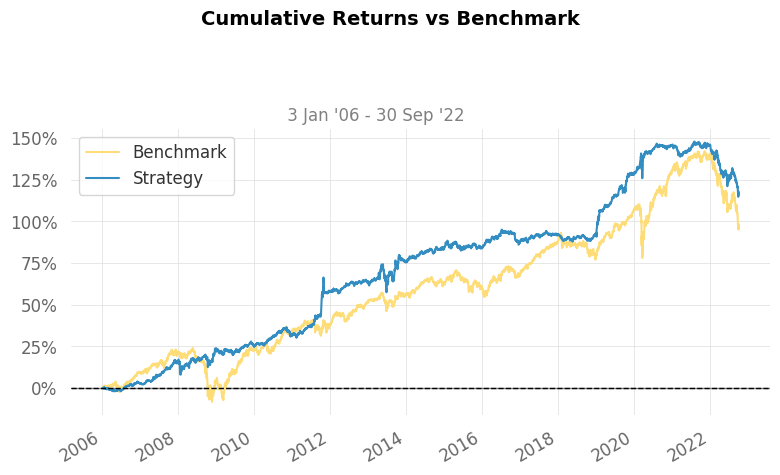

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


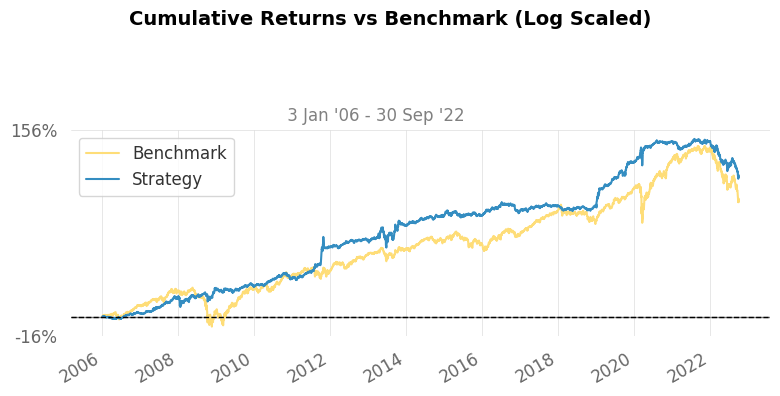

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


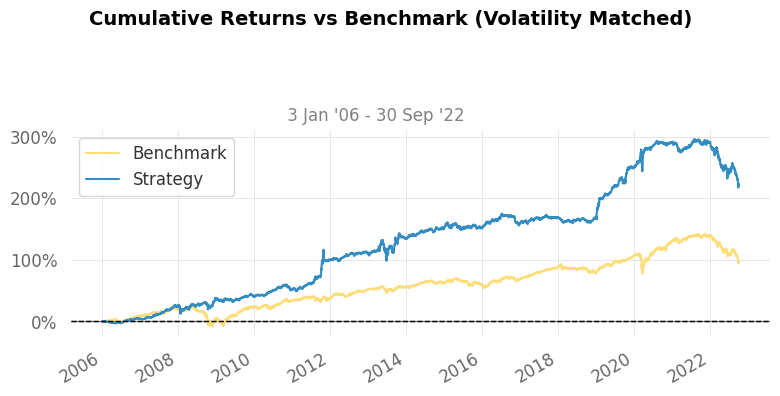

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


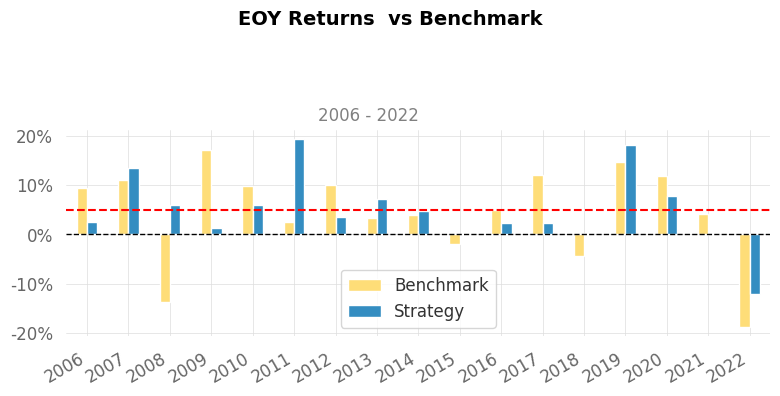

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


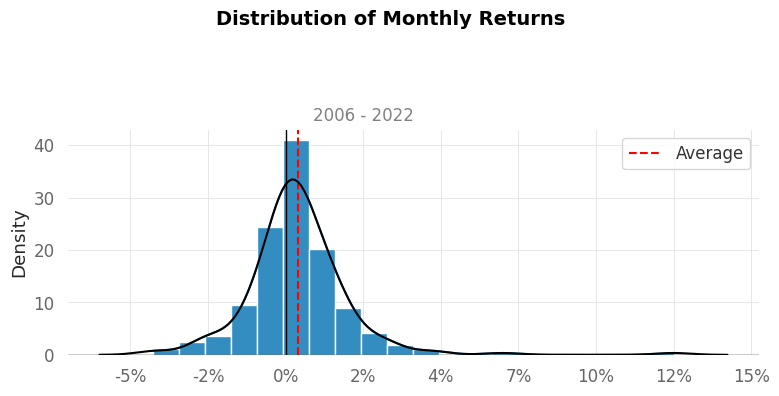

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


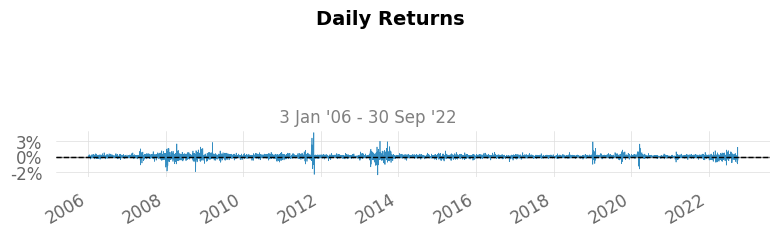

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


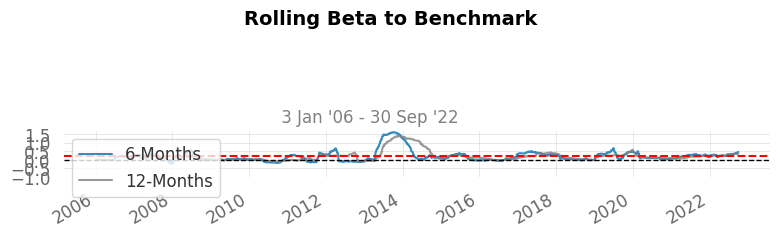

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


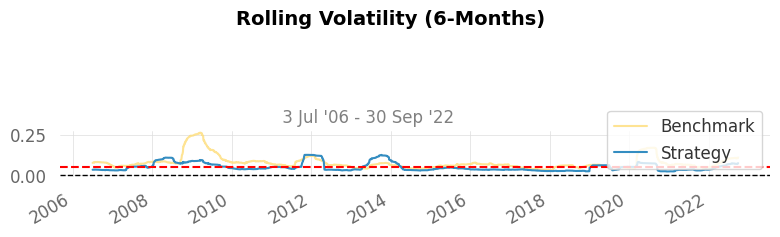

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


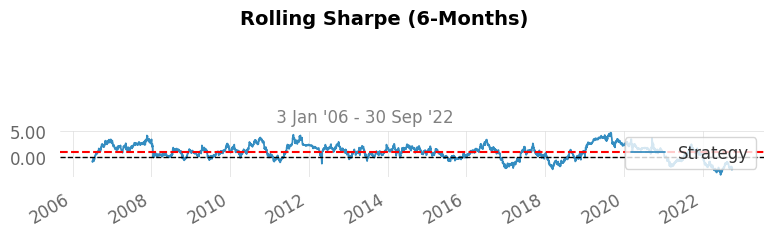

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


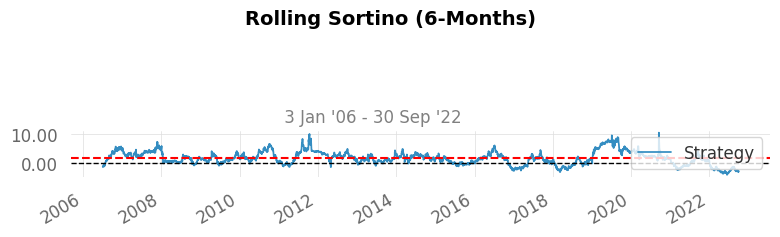

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


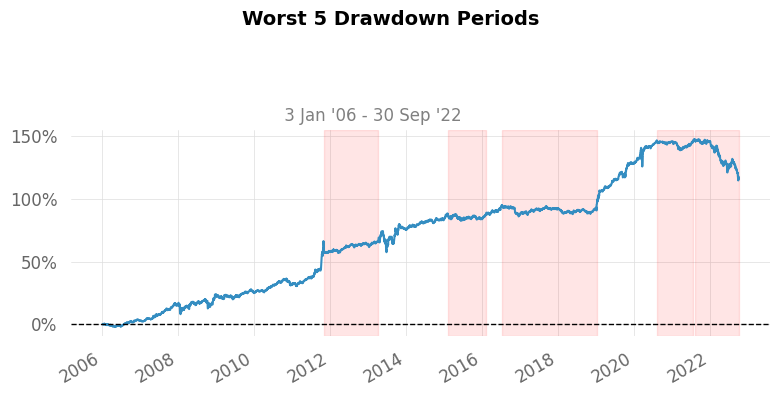

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


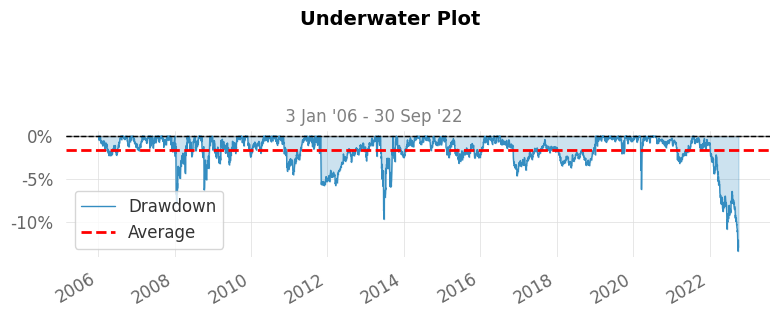

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


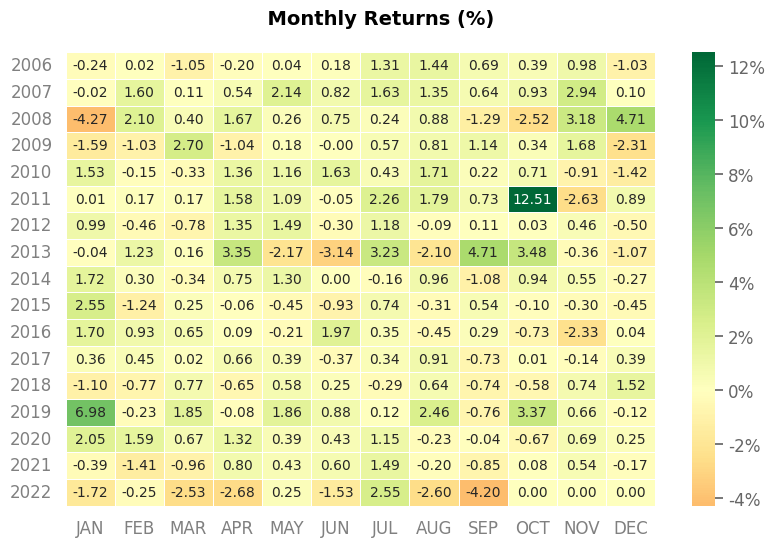

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


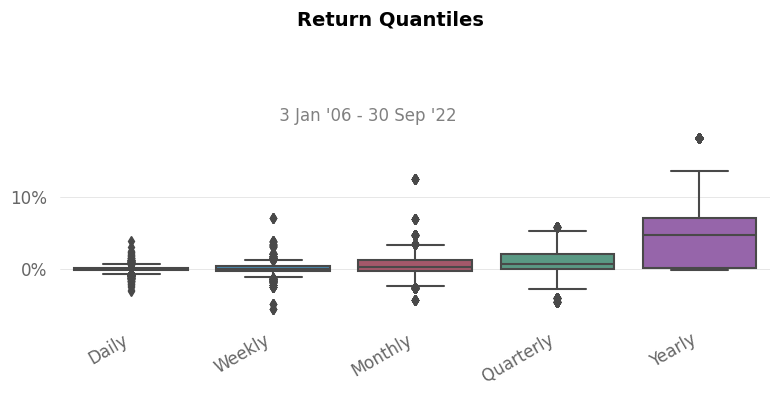

In [14]:
quantstats.reports.full(returns=myasset, benchmark=benchmark1)

In [15]:
historical_portfolio = engine.asset_df
weight_historical_portfolio = pd.DataFrame(index=historical_portfolio.index, columns=historical_portfolio.columns)
for date in historical_portfolio.index:
    for ticker in historical_portfolio.columns:
        weight_historical_portfolio.loc[date,ticker] = historical_portfolio.loc[date,ticker]/historical_portfolio.loc[date].sum(axis=0)
weight_historical_portfolio

,cash,EEM,EFA,SPY,LQD,TIP,AGG,IEF,SHY
2006-01-03,0.0,0.0,0.0,0.0,0.0,0.25,0.25,0.25,0.25
2006-01-04,0.0,0.0,0.0,0.0,0.0,0.249695,0.250267,0.250118,0.24992
2006-01-05,0.0,0.0,0.0,0.0,0.0,0.249189,0.250489,0.250399,0.249924
2006-01-06,0.0,0.0,0.0,0.0,0.0,0.249307,0.250157,0.250311,0.250226
2006-01-09,0.0,0.0,0.0,0.0,0.0,0.24942,0.250251,0.250251,0.250078
...,...,...,...,...,...,...,...,...,...
2022-09-26,0.0,0.0,0.0,0.0,0.0,0.246496,0.249301,0.247647,0.256556
2022-09-27,0.0,0.0,0.0,0.0,0.0,0.246191,0.249248,0.246959,0.257602
2022-09-28,0.0,0.0,0.0,0.0,0.0,0.246828,0.249512,0.248779,0.25488
2022-09-29,0.0,0.0,0.0,0.0,0.0,0.244908,0.249767,0.249184,0.256142


<AxesSubplot: >

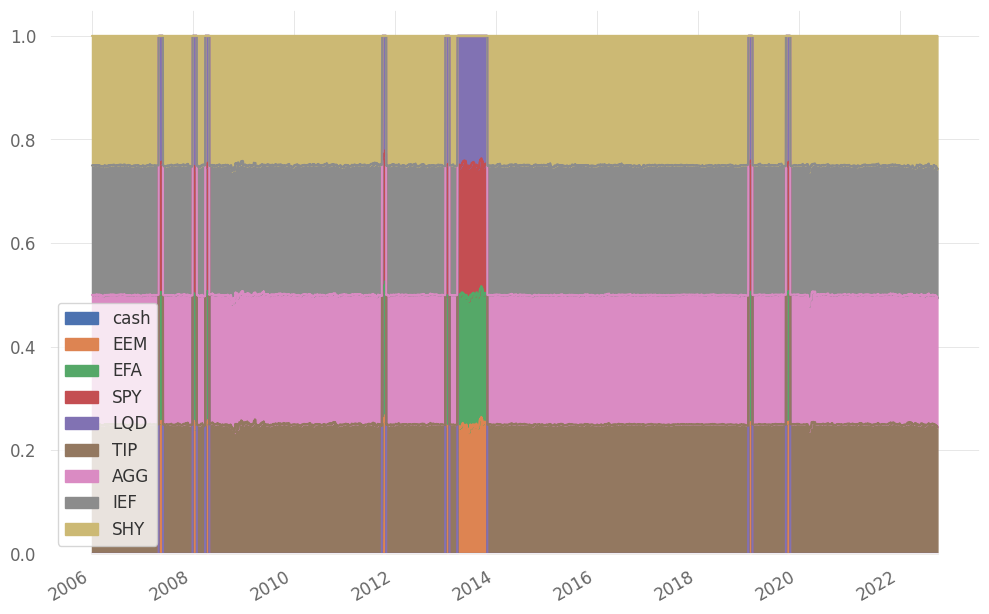

In [16]:
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)
weight_historical_portfolio.plot.area()